In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('/Users/firo/Desktop/BMI/SPH6004/Assignment_1_data.csv')
data.head()

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_indirect_min,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,M,54.550390,93.0,115.0,103.500000,57.0,100.0,82.733333,87.0,163.0,...,NaN,3459.0,2.0,0.0,NaN,1.0,0.0,1.0,3,False
1,M,86.324653,50.0,61.0,54.333333,61.0,93.0,71.695652,95.0,141.0,...,NaN,2020.0,NaN,1.0,NaN,1.0,1.0,1.0,8,False
2,M,40.270146,70.0,105.0,83.434783,66.0,92.0,76.695652,94.0,129.0,...,NaN,3050.0,NaN,1.0,0.0,1.0,1.0,0.0,4,False
3,M,73.383547,68.0,98.0,83.880000,74.0,101.0,84.694444,83.0,148.0,...,NaN,1592.0,NaN,0.0,NaN,0.0,0.0,1.0,6,False
4,M,70.724748,77.0,95.0,85.771429,30.0,90.0,62.657143,52.0,129.0,...,NaN,339.0,2.0,0.0,0.0,4.0,1.0,3.0,10,False


In [23]:
temp_cols = []
# Select the variables with the amount of missing values greater than 10,000 and then delete them
for col,value in zip(data.isnull().sum().index,data.isnull().sum().values):
    if value > 10000:
        temp_cols.append(col)
# Delete variables with missing values greater than 10000
data.drop(temp_cols,axis=1,inplace=True)
# Delete missing values
data.dropna(inplace=True)
# Drop variables that are least important based on feature importance score
data.drop(columns=['sofa_coagulation','sofa_cardiovascular','sofa_renal'],inplace=True)
data.shape

(30617, 31)

In [24]:
data.columns

Index(['gender', 'age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'sbp_min', 'sbp_max', 'sbp_mean',
       'dbp_min', 'dbp_max', 'dbp_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'glucose_min', 'glucose_max', 'wbc_min', 'wbc_max',
       'creatinine_min', 'creatinine_max', 'hemoglobin_min', 'hemoglobin_max',
       'pt_min', 'pt_max', 'urineoutput', 'sofa_cns',
       'charlson_comorbidity_index', 'outcome'],
      dtype='object')

In [25]:
data['outcome'].value_counts()   # The results show that the data is seriously unbalanced and needs to be processed

False    29412
True      1205
Name: outcome, dtype: int64

In [4]:
new_df = pd.DataFrame() # Construct a new df to store data['outcome']==True
# Generate a df with data['outcome']==True using a loop, which is equivalent to expanding the amount of data with data['outcome']==True
for i in range(len(data[data['outcome']==False])):  
    a = data[data['outcome']==True].sample(1)  # Randomly select a data['outcome']==True
    new_df = new_df.append(a)  

In [5]:
new_data = pd.concat([data,new_df])  
new_data['gender'].replace(to_replace={'M':1,'F':0},inplace=True)
new_data['outcome'].replace(to_replace={False:0,True:1},inplace=True) 

In [6]:
from sklearn.model_selection import train_test_split
X = new_data.drop('outcome',axis=1)
y = new_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Build a decision tree model
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
tree.score(X_test,y_test)

0.9792603698150925

In [8]:
# Construct a logistic regression model
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train,y_train)
lg.score(X_test,y_test)

0.6465933699816758

In [9]:
# Build a support vector machine model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.5817091454272864

Model Confusion Matrix: [[5584  241]
 [   0 6181]]
Model Classification Report:               precision    recall  f1-score   support

           0       1.00      0.96      0.98      5825
           1       0.96      1.00      0.98      6181

    accuracy                           0.98     12006
   macro avg       0.98      0.98      0.98     12006
weighted avg       0.98      0.98      0.98     12006



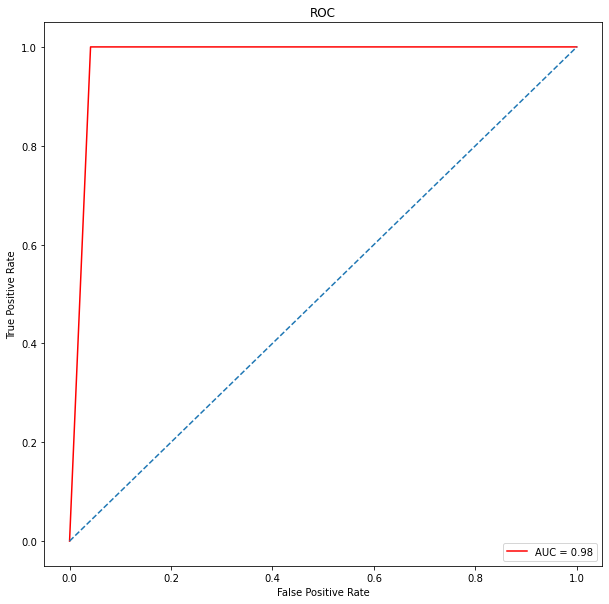

In [36]:
# Among the accuracy of the above three models, the decision tree is the best, so the decision tree is chosen

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc
y_pred = tree.predict(X_test)
print('Model Confusion Matrix:',confusion_matrix(y_test,y_pred))
print('Model Classification Report:',classification_report(y_test,y_pred))
# Draw ROCs
y_prob = tree.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob) 
roc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,10))
plt.title('ROC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1 sofa_cns 0.15328593245108188
2 age 0.04575544034330502
3 urineoutput 0.0409129286281243
4 temperature_mean 0.03537740004080949
5 heart_rate_mean 0.0346063117341833
6 wbc_max 0.034234742292134496
7 glucose_max 0.0337492549948373
8 pt_max 0.03270558541966562
9 wbc_min 0.031973208750848796
10 pt_min 0.031156720796419426
11 temperature_max 0.030909042601167804
12 sbp_mean 0.029526658788377236
13 heart_rate_max 0.029216483427972464
14 glucose_min 0.028984055542655256
15 hemoglobin_min 0.028334952047340725
16 dbp_max 0.02795179379357126
17 heart_rate_min 0.02742899129337473
18 sbp_min 0.027261509171753618
19 hemoglobin_max 0.027244053184197745
20 dbp_mean 0.02702517519053091
21 sbp_max 0.026970988237092715
22 mbp_mean 0.026862525423520255
23 temperature_min 0.026599174019017773
24 mbp_max 0.026295104321723252
25 dbp_min 0.02437021979531054
26 mbp_min 0.02358219919104468
27 creatinine_max 0.023147084268005734
28 creatinine_min 0.02152731174605327
29 charlson_comorbidity_index 0.020424624288

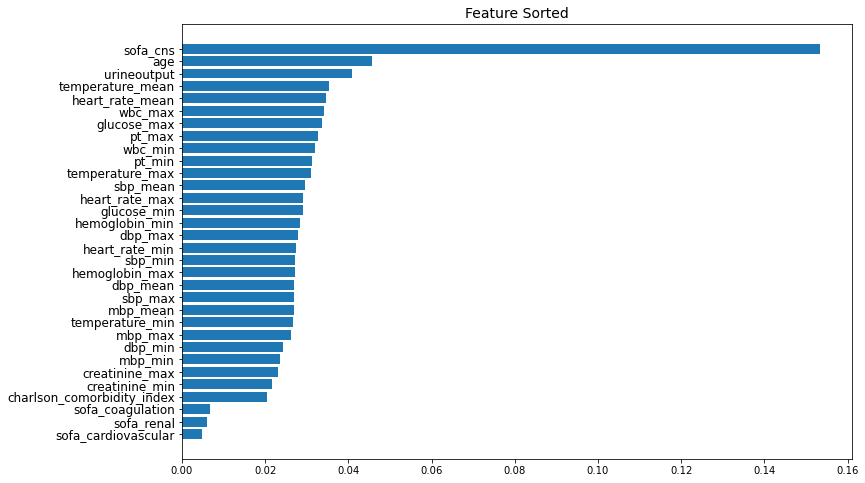

In [35]:
#Printing feature importance scores
import numpy as np
feat_labels = X_train.columns[0:]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for f,j in zip(range(X_train.shape[1]-1),indices):
    index_list.append(feat_labels[j])
    value_list.append(importances[j])
    print(f + 1, feat_labels[j], importances[j])
plt.figure(figsize=(12,8))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize=12)
plt.title('Feature Sorted',fontsize=14)
plt.show()